In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import warnings
import time
import gc
from tqdm import trange

warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 0)
pd.set_option('display.max_columns', 0)

# Load Data and Preprocessing

## UNSW-NB15

In [2]:
# Load Data
train_raw = pd.read_csv('../Data/UNSW_NB15/train.csv')
print(train_raw.shape)
test_raw = pd.read_csv('../Data/UNSW_NB15/test.csv')
print(test_raw.shape)
# Seperate label and drop unnecessary features
train_X = train_raw.drop(['id', 'attack_cat', 'label'], axis=1).select_dtypes(include='number')
print(train_X.shape)
train_Y = train_raw['label']
test_X = test_raw.drop(['id', 'attack_cat', 'label'], axis=1).select_dtypes(include='number')
print(test_X.shape)
test_Y = test_raw['label']

(82332, 45)
(175341, 45)
(82332, 39)
(175341, 39)


## NSL-KDD

In [2]:
# Load Data
train_raw = pd.read_csv('../Data/NSL_KDD/train.csv')
print(train_raw.shape)
test_raw = pd.read_csv('../Data/NSL_KDD/test.csv')
print(test_raw.shape)

# Seperate label and Drop ID
def LabelEncode(x):
    if x == 'normal':
        return 0
    else:
        return 1
train_X = train_raw.drop(['class'], axis=1).select_dtypes(include='number')
print(train_X.shape)
train_Y = train_raw['class'].apply(LabelEncode)
test_X = test_raw.drop(['class'], axis=1).select_dtypes(include='number')
print(test_X.shape)
test_Y = test_raw['class'].apply(LabelEncode)

(125973, 42)
(22544, 42)
(125973, 38)
(22544, 38)


## CICIDS-2017

In [2]:
# Load Data
train_raw = pd.read_csv('../Data/CICIDS_2017/train.csv')
print(train_raw.shape)
test_raw = pd.read_csv('../Data/CICIDS_2017/test.csv')
print(test_raw.shape)

# Seperate label and Drop ID
def LabelEncode(x):
    if x == 'BENIGN':
        return 0
    else:
        return 1
train_X = train_raw.drop(['Unnamed: 0.1', 'Unnamed: 0', ' Label'], axis=1).select_dtypes(include='number')
print(train_X.shape)
train_Y = train_raw[' Label'].apply(LabelEncode)
test_X = test_raw.drop(['Unnamed: 0.1', 'Unnamed: 0', ' Label'], axis=1).select_dtypes(include='number')
print(test_X.shape)
test_Y = test_raw[' Label'].apply(LabelEncode)

(500000, 81)
(500000, 81)
(500000, 78)
(500000, 78)


# Feature Selection

In [3]:
# Normalize data with min, max of training data
test_X1 = (test_X - train_X.min(axis=0)) / (train_X.max(axis=0) - train_X.min(axis=0))
train_X1 = (train_X - train_X.min(axis=0)) / (train_X.max(axis=0) - train_X.min(axis=0))

test_X1[test_X1 < 0] = 0
test_X1[test_X1 > 1] = 1

train_X1.fillna(0, inplace=True)
test_X1.fillna(0, inplace=True)

In [4]:
# correlation based feature selection
corr = train_X1.corr().abs()

correlation_threshold = 0.8
corr.values[np.tril_indices_from(corr.values)] = np.nan
redundant = []
for j in corr.columns:
    for i in corr.index:
        if corr.loc[i, j] > correlation_threshold:
            redundant.append((i, j))

train_corr = train_X1.copy()
train_corr['Label'] = train_Y
corr2 = train_corr.corr().abs()

corr3 = corr2['Label'].iloc[:-1].copy()
drop = []

# drop features having lower correlation with label
for i, j in redundant:
    if corr3[i] > corr3[j]:
        if j not in drop:
            drop.append(j)
    elif i not in drop:
        drop.append(i)
print(drop)

# 
del corr, train_corr, corr2, corr3
gc.collect()

train_X1 = train_X1.drop(drop, axis=1)
print(train_X1.shape)
test_X1 = test_X1.drop(drop, axis=1)
print(test_X1.shape)

[' Total Backward Packets', ' Total Length of Bwd Packets', ' Fwd Packet Length Max', ' Fwd Packet Length Std', ' Bwd Packet Length Mean', 'Bwd Packet Length Max', ' Flow IAT Std', ' Flow Duration', ' Fwd IAT Mean', ' Flow IAT Max', ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Max', ' Max Packet Length', ' Packet Length Mean', ' Packet Length Std', ' Packet Length Variance', 'Fwd PSH Flags', ' Fwd URG Flags', ' RST Flag Count', ' Average Packet Size', ' Fwd Packet Length Mean', ' Avg Bwd Segment Size', ' Fwd Header Length', ' Total Fwd Packets', 'Total Length of Fwd Packets', ' Subflow Bwd Packets', ' Subflow Bwd Bytes', ' act_data_pkt_fwd', ' Fwd Header Length.1', 'Active Mean', 'Idle Mean', ' Idle Max', ' Idle Min']
(500000, 42)
(500000, 42)


In [5]:
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearnex import patch_sklearn, unpatch_sklearn

patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [6]:
dataset_name = 'CICIDS_2017'
methods = ['union', 'intersection', 'quorum']
indices = ['union', 'union_size', 'intersection', 'intersection_size', 'quorum', 'quorum_size']
colors = ['blue', 'red', 'black', 'cyan', 'darkcyan', 'green', 'darkgreen']
n_of_features = train_X1.shape[1]
kf = StratifiedKFold(shuffle=True, random_state=0)
subset_all = pd.read_csv('../Results/' + dataset_name + '/Individual_Features.csv')

In [7]:
union_all = []
union_size_all = []
intersection_all = []
intersection_size_all = []
quorum_all = []
quorum_size_all = []

for k in trange(n_of_features):
    union = []
    intersection = []
    quorum = []
    for c in train_X1.columns:
        candidates = subset_all.iloc[:, 1:k+2]
        count = np.count_nonzero(candidates == c)
        if count > 0:
            union.append(c)
        if count > len(subset_all) / 2:
            quorum.append(c)
        if count == len(subset_all):
            intersection.append(c)
    union_all.append(union)
    union_size_all.append(len(union))
    intersection_all.append(intersection)
    intersection_size_all.append(len(intersection))
    quorum_all.append(quorum)
    quorum_size_all.append(len(quorum))
print(union_size_all)
print(intersection_size_all)
print(quorum_size_all)

100%|██████████| 42/42 [00:00<00:00, 227.64it/s]

[6, 9, 12, 16, 18, 20, 23, 25, 25, 25, 27, 29, 31, 31, 33, 34, 35, 35, 35, 35, 35, 36, 36, 36, 36, 36, 36, 36, 37, 38, 39, 40, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 5, 5, 5, 5, 7, 7, 8, 8, 8, 9, 10, 13, 15, 15, 16, 18, 21, 22, 23, 24, 25, 27, 28, 31, 35, 37, 42]
[0, 0, 2, 2, 2, 2, 3, 5, 7, 9, 10, 10, 13, 14, 14, 14, 16, 16, 19, 20, 23, 24, 25, 27, 27, 28, 30, 30, 31, 31, 32, 32, 33, 34, 35, 37, 39, 39, 40, 40, 42, 42]


In [8]:
set_all = []
set_all.append(union_all)
set_all.append(union_size_all)
set_all.append(intersection_all)
set_all.append(intersection_size_all)
set_all.append(quorum_all)
set_all.append(quorum_size_all)
print(len(set_all))
print(len(set_all[0]))
pd.DataFrame(set_all, index=indices).to_csv('../Results/' + dataset_name + '/Set_Features.csv')

6
42


# Cross Validation and Test

## Linear Regression

In [9]:
cv_time_all_LR = []
cv_f1_all_LR = []
test_time_all_LR = []
test_f1_all_LR = []
model = RidgeClassifier(alpha=0.01, random_state=0)
for all in [union_all, intersection_all, quorum_all]:
    cv_time = []
    cv_f1 = []
    test_time = []
    test_f1 = []
    for k in trange(len(all)):
        # cross validation
        if len(all[k]) > 0:
            second = time.time()
            cv = cross_val_score(model, train_X1[all[k]], train_Y, scoring='f1', n_jobs=-1)
            second2 = time.time()
            cv_time.append(second2 - second)
            cv_f1.append((cv.mean(), cv.std()))

            model.fit(train_X1[all[k]], train_Y)
            second = time.time()
            predict = model.predict(test_X1[all[k]])
            score = f1_score(test_Y, predict)
            second2 = time.time()
            test_time.append(second2 - second)
            test_f1.append(score)
        else:
            cv_time.append(0)
            cv_f1.append((0, 0))
            test_time.append(0)
            test_f1.append(0)

    cv_time_all_LR.append(cv_time)
    cv_f1_all_LR.append(cv_f1)
    test_time_all_LR.append(test_time)
    test_f1_all_LR.append(test_f1)

100%|██████████| 42/42 [00:52<00:00,  1.24s/it]


In [10]:
pd.DataFrame(cv_time_all_LR, index=['union', 'intersection', 'quorum']).to_csv('../Results/' + dataset_name + '/Set_CV_Time_LR.csv')
pd.DataFrame(cv_f1_all_LR, index=['union', 'intersection', 'quorum']).to_csv('../Results/' + dataset_name + '/Set_CV_F1_LR.csv')
pd.DataFrame(test_time_all_LR, index=['union', 'intersection', 'quorum']).to_csv('../Results/' + dataset_name + '/Set_Test_Time_LR.csv')
pd.DataFrame(test_f1_all_LR, index=['union', 'intersection', 'quorum']).to_csv('../Results/' + dataset_name + '/Set_Test_F1_LR.csv')

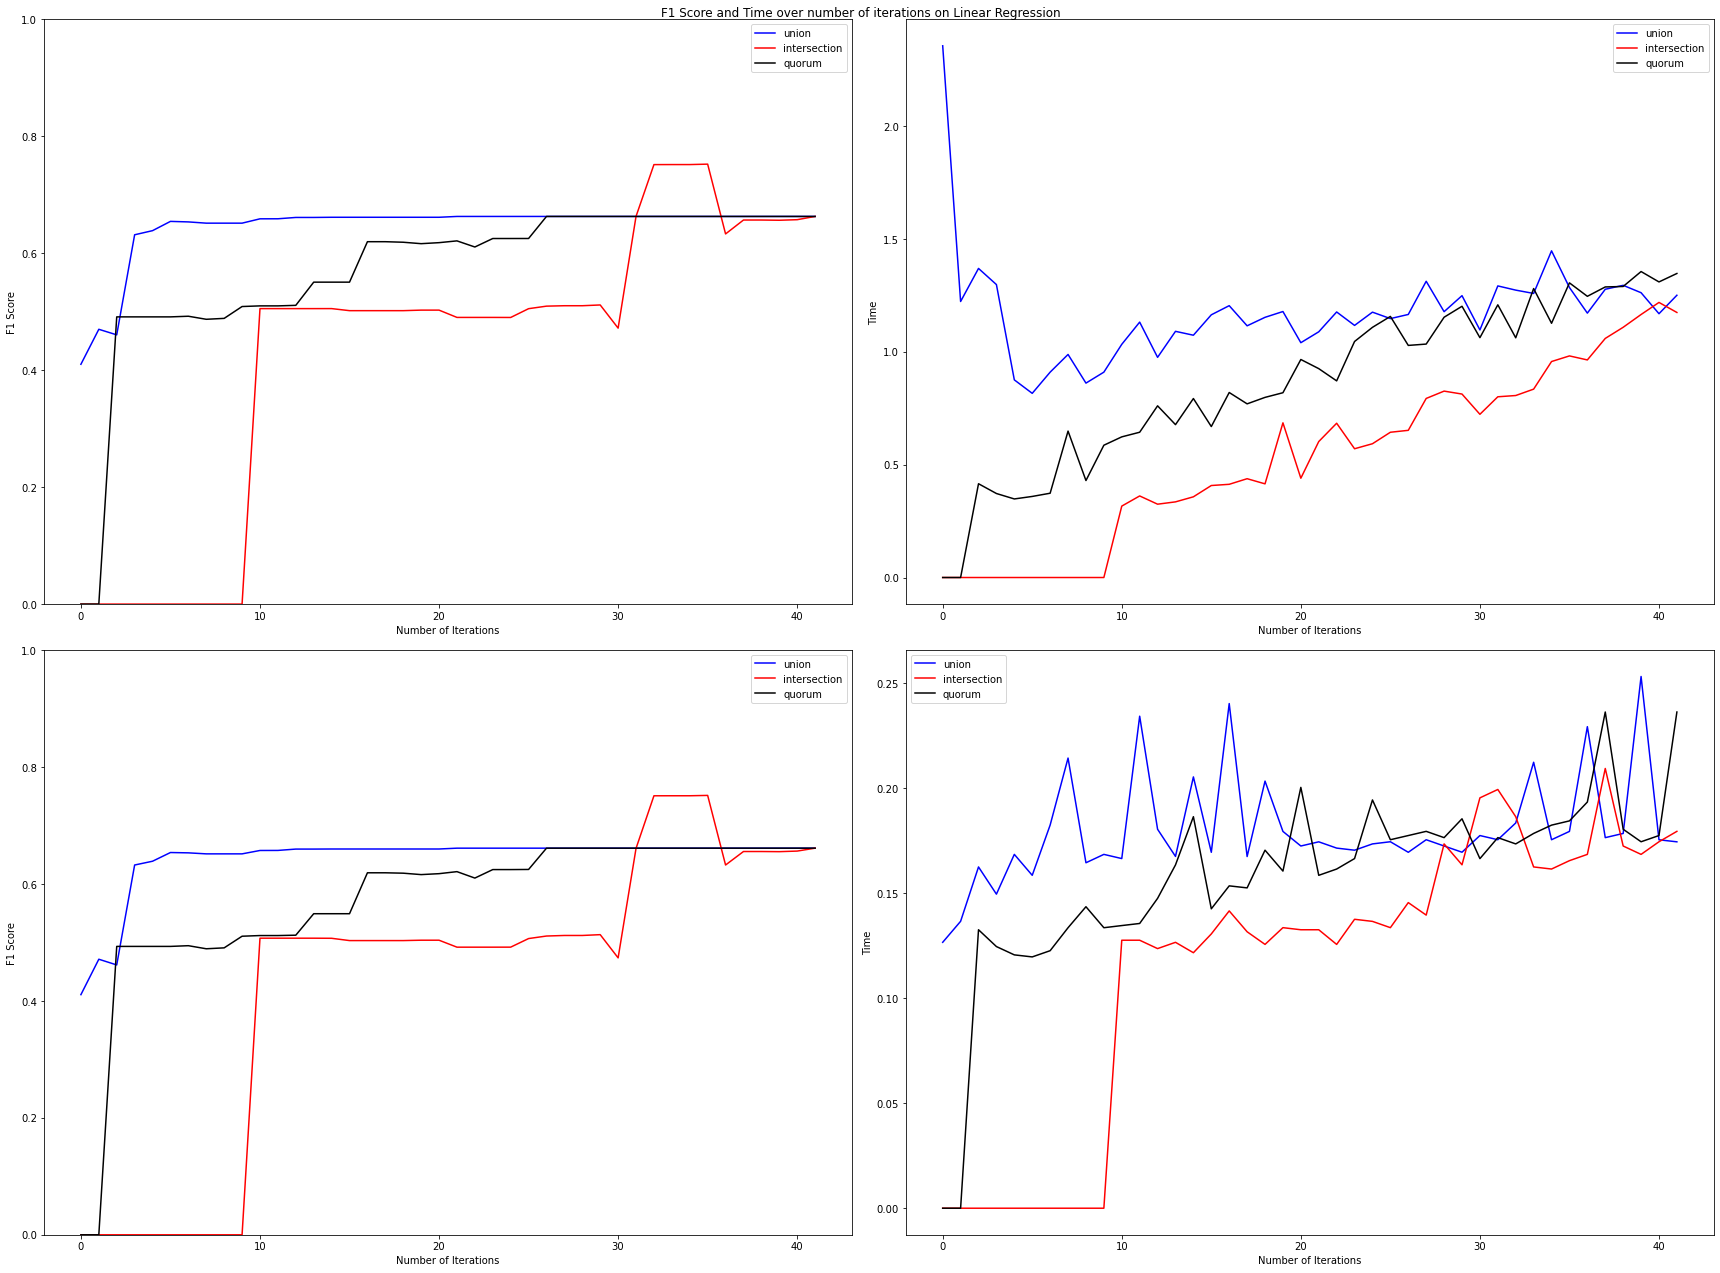

In [15]:
fig, axis = plt.subplots(2, 2, figsize=(24, 18))

plt.suptitle('F1 Score and Time over number of iterations on Linear Regression')
plt.subplot(2, 2, 1)
plt.xlabel('Number of Iterations')
plt.ylabel('F1 Score')
plt.ylim((0, 1))

for i in range(len(methods)):
    plt.plot(range(n_of_features), np.array(cv_f1_all_LR)[i,:,0], color=colors[i], linestyle='-', label=methods[i])

plt.legend()

plt.subplot(2, 2, 2)
plt.xlabel('Number of Iterations')
plt.ylabel('Time')

for i in range(len(methods)):
    plt.plot(range(n_of_features), cv_time_all_LR[i], color=colors[i], linestyle='-', label=methods[i])

plt.legend()

plt.subplot(2, 2, 3)
plt.xlabel('Number of Iterations')
plt.ylabel('F1 Score')
plt.ylim((0, 1))

for i in range(len(methods)):
    plt.plot(range(n_of_features), np.array(test_f1_all_LR)[i,:], color=colors[i], linestyle='-', label=methods[i])

plt.legend()

plt.subplot(2, 2, 4)
plt.xlabel('Number of Iterations')
plt.ylabel('Time')

for i in range(len(methods)):
    plt.plot(range(n_of_features), test_time_all_LR[i], color=colors[i], linestyle='-', label=methods[i])

plt.legend()

plt.tight_layout()
plt.savefig('../Evaluation/' + dataset_name + '/Set_LR.png')

## Gradient Boosting

In [12]:
cv_time_all_GB = []
cv_f1_all_GB = []
test_time_all_GB = []
test_f1_all_GB = []
model = GradientBoostingClassifier(n_estimators=200, random_state=0)
for all in [union_all, intersection_all, quorum_all]:
    cv_time = []
    cv_f1 = []
    test_time = []
    test_f1 = []
    for k in trange(len(all)):
        # cross validation
        if len(all[k]) > 0:
            second = time.time()
            cv = cross_val_score(model, train_X1[all[k]], train_Y, scoring='f1', n_jobs=-1)
            second2 = time.time()
            cv_time.append(second2 - second)
            cv_f1.append((cv.mean(), cv.std()))

            model.fit(train_X1[all[k]], train_Y)
            second = time.time()
            predict = model.predict(test_X1[all[k]])
            score = f1_score(test_Y, predict)
            second2 = time.time()
            test_time.append(second2 - second)
            test_f1.append(score)
        else:
            cv_time.append(0)
            cv_f1.append((0, 0))
            test_time.append(0)
            test_f1.append(0)

    cv_time_all_GB.append(cv_time)
    cv_f1_all_GB.append(cv_f1)
    test_time_all_GB.append(test_time)
    test_f1_all_GB.append(test_f1)

100%|██████████| 42/42 [4:06:12<00:00, 351.72s/it]  


In [13]:
pd.DataFrame(cv_time_all_GB, index=['union', 'intersection', 'quorum']).to_csv('../Results/' + dataset_name + '/Set_CV_Time_GB.csv')
pd.DataFrame(cv_f1_all_GB, index=['union', 'intersection', 'quorum']).to_csv('../Results/' + dataset_name + '/Set_CV_F1_GB.csv')
pd.DataFrame(test_time_all_GB, index=['union', 'intersection', 'quorum']).to_csv('../Results/' + dataset_name + '/Set_Test_Time_GB.csv')
pd.DataFrame(test_f1_all_GB, index=['union', 'intersection', 'quorum']).to_csv('../Results/' + dataset_name + '/Set_Test_F1_GB.csv')

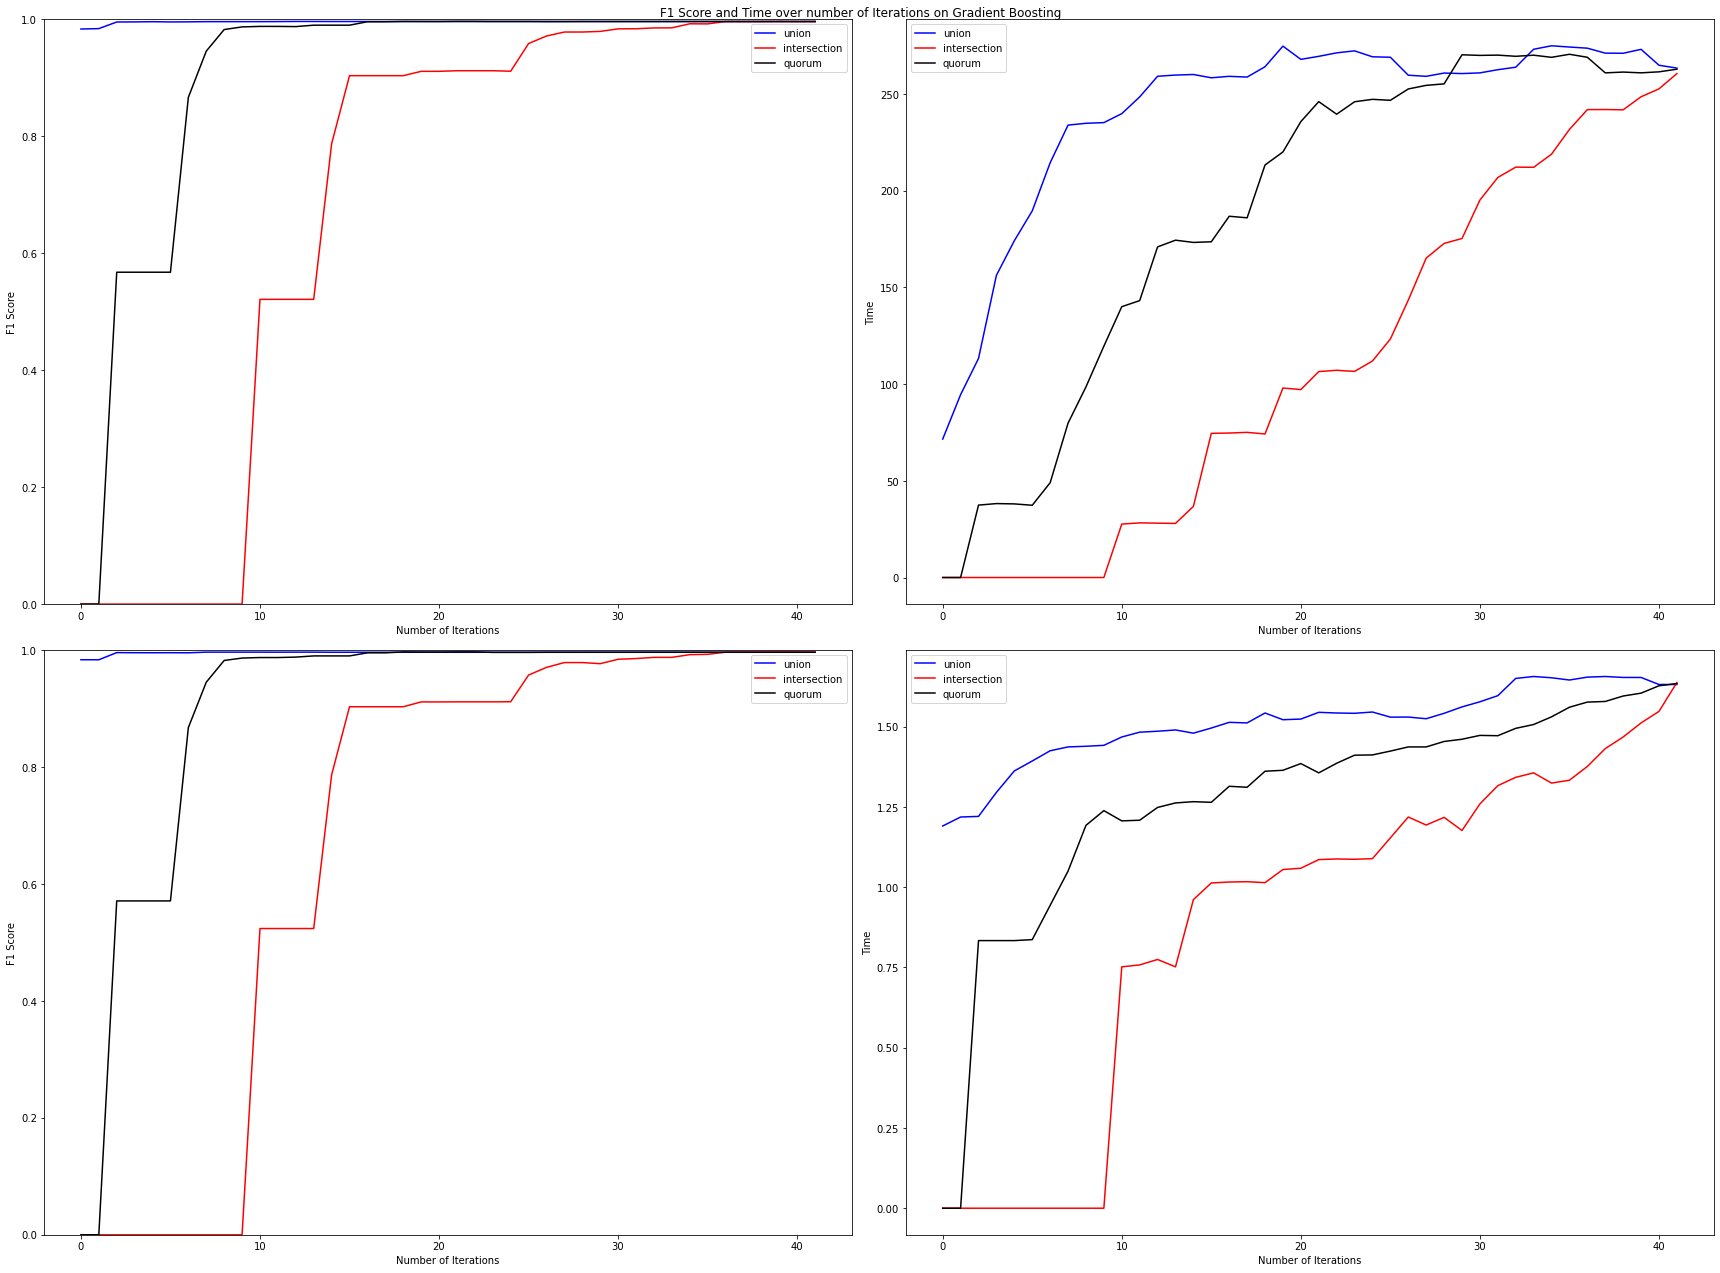

In [16]:
fig, axis = plt.subplots(2, 2, figsize=(24, 18))

plt.suptitle('F1 Score and Time over number of Iterations on Gradient Boosting')
plt.subplot(2, 2, 1)
plt.xlabel('Number of Iterations')
plt.ylabel('F1 Score')
plt.ylim((0, 1))

for i in range(len(methods)):
    plt.plot(range(n_of_features), np.array(cv_f1_all_GB)[i,:,0], color=colors[i], linestyle='-', label=methods[i])

plt.legend()

plt.subplot(2, 2, 2)
plt.xlabel('Number of Iterations')
plt.ylabel('Time')

for i in range(len(methods)):
    plt.plot(range(n_of_features), cv_time_all_GB[i], color=colors[i], linestyle='-', label=methods[i])

plt.legend()

plt.subplot(2, 2, 3)
plt.xlabel('Number of Iterations')
plt.ylabel('F1 Score')
plt.ylim((0, 1))

for i in range(len(methods)):
    plt.plot(range(n_of_features), np.array(test_f1_all_GB)[i,:], color=colors[i], linestyle='-', label=methods[i])

plt.legend()

plt.subplot(2, 2, 4)
plt.xlabel('Number of Iterations')
plt.ylabel('Time')

for i in range(len(methods)):
    plt.plot(range(n_of_features), test_time_all_GB[i], color=colors[i], linestyle='-', label=methods[i])

plt.legend()

plt.tight_layout()
plt.savefig('../Evaluation/' + dataset_name + '/Set_GB.png')

## Neuron Network

In [17]:
from tensorflow.keras import Sequential, layers, optimizers, losses, metrics, callbacks

In [18]:
n_epoch = 15
batch_size = 100

In [19]:
def ModelCreate(input_shape):
    model = Sequential()
    model.add(layers.Dense(50, activation='relu', input_shape=input_shape))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(50, activation='relu', input_shape=input_shape))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(50, activation='relu', input_shape=input_shape))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(50, activation='relu', input_shape=input_shape))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizers.Adam(), loss=losses.binary_crossentropy, metrics=[metrics.binary_accuracy])
    return model

In [20]:
cv_time_all_NN = []
cv_f1_all_NN = []
test_time_all_NN = []
test_f1_all_NN = []
kf = StratifiedKFold(shuffle=True, random_state=0)
callback = callbacks.EarlyStopping(patience=3, min_delta=0.1, restore_best_weights=True)
for all in [union_all, intersection_all, quorum_all]:
    cv_time = []
    cv_f1 = []
    test_time = []
    test_f1 = []
    for k in trange(len(all)):
        if len(all[k]) > 0:
            model = ModelCreate((len(all[k]),))
            # cross validation
            j = 0
            cv_time_ = 0
            cv = np.zeros(shape=5)
            train_X2 = train_X1[all[k]].copy()
            for train_index, test_index in kf.split(train_X2, train_Y):
                x_train_fold, x_test_fold = train_X2.iloc[train_index, :], train_X2.iloc[test_index, :]
                y_train_fold, y_test_fold = train_Y.iloc[train_index], train_Y.iloc[test_index]

                second = time.time()
                model.fit(x_train_fold.values, y_train_fold.values, batch_size=1024, validation_data=(x_test_fold, y_test_fold), epochs=30, callbacks=[callback], verbose=0)
                predict = model.predict(x_test_fold, use_multiprocessing=True)
                predict = np.where(predict < 0.5, 0, 1)
                cv[j] = f1_score(y_test_fold, predict)
                second2 = time.time()
                cv_time_ += second2 - second
                j += 1
            cv_time.append(cv_time_)
            cv_f1.append((cv.mean(), cv.std()))

            second = time.time()
            model.fit(train_X1[all[k]].values, train_Y.values,
                    epochs=n_epoch, batch_size=batch_size,
                    use_multiprocessing=True, verbose=0)
            predict = model.predict(test_X1[all[k]], use_multiprocessing=True)
            predict = np.where(predict < 0.5, 0, 1)
            score = f1_score(test_Y, predict)
            second2 = time.time()
            test_time.append(second2-second)
            test_f1.append(score)
        else:
            cv_time.append(0)
            cv_f1.append((0, 0))
            test_time.append(0)
            test_f1.append(0)
    
    cv_time_all_NN.append(cv_time)
    cv_f1_all_NN.append(cv_f1)
    test_time_all_NN.append(test_time)
    test_f1_all_NN.append(test_f1)

100%|██████████| 42/42 [3:32:47<00:00, 304.00s/it]  


In [21]:
pd.DataFrame(cv_time_all_NN, index=['union', 'intersection', 'quorum']).to_csv('../Results/' + dataset_name + '/Set_CV_Time_NN.csv')
pd.DataFrame(cv_f1_all_NN, index=['union', 'intersection', 'quorum']).to_csv('../Results/' + dataset_name + '/Set_CV_F1_NN.csv')
pd.DataFrame(test_time_all_NN, index=['union', 'intersection', 'quorum']).to_csv('../Results/' + dataset_name + '/Set_Test_Time_NN.csv')
pd.DataFrame(test_f1_all_NN, index=['union', 'intersection', 'quorum']).to_csv('../Results/' + dataset_name + '/Set_Test_F1_NN.csv')

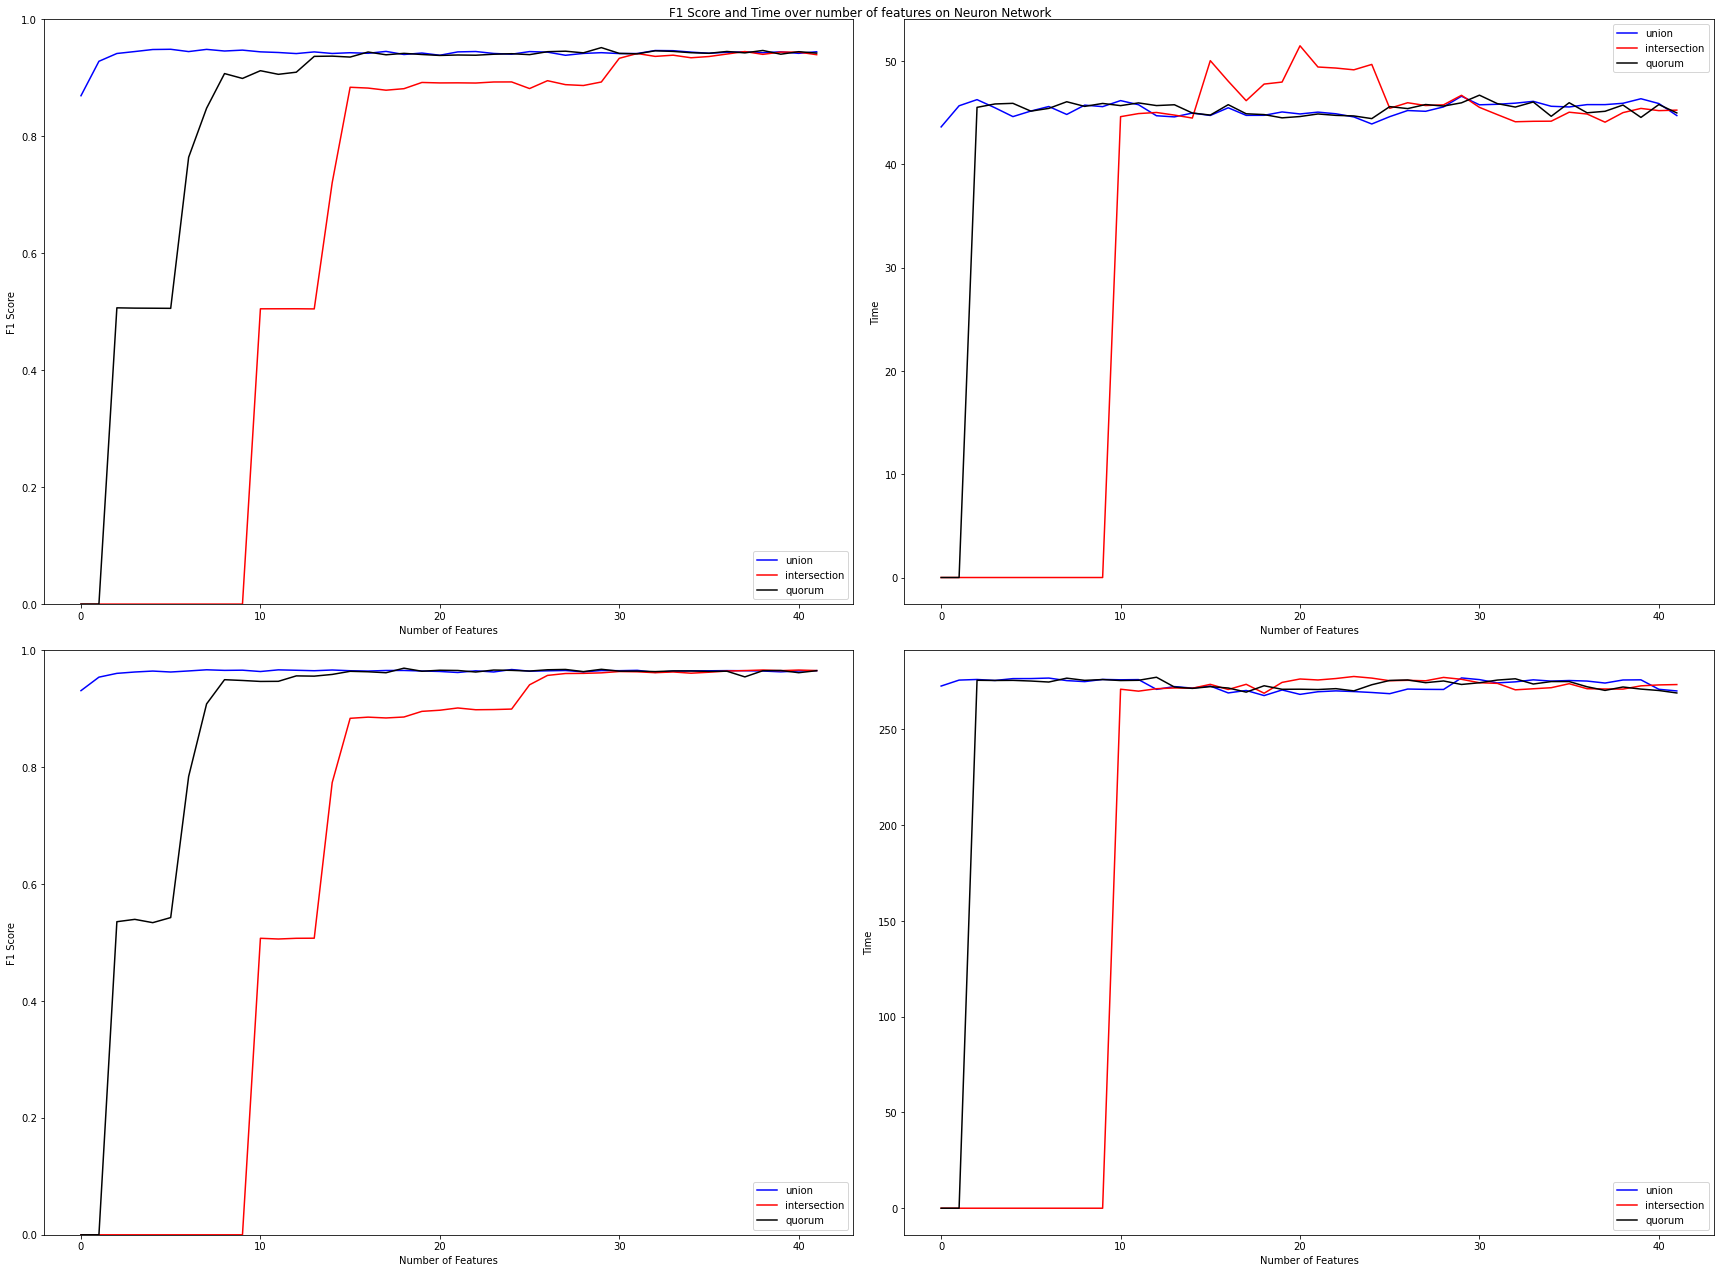

In [22]:
fig, axis = plt.subplots(2, 2, figsize=(24, 18))

plt.suptitle('F1 Score and Time over number of features on Neuron Network')
plt.subplot(2, 2, 1)
plt.xlabel('Number of Features')
plt.ylabel('F1 Score')
plt.ylim((0, 1))

for i in range(len(methods)):
    plt.plot(range(n_of_features), np.array(cv_f1_all_NN)[i,:,0], color=colors[i], linestyle='-', label=methods[i])

plt.legend()

plt.subplot(2, 2, 2)
plt.xlabel('Number of Features')
plt.ylabel('Time')

for i in range(len(methods)):
    plt.plot(range(n_of_features), cv_time_all_NN[i], color=colors[i], linestyle='-', label=methods[i])

plt.legend()

plt.subplot(2, 2, 3)
plt.xlabel('Number of Features')
plt.ylabel('F1 Score')
plt.ylim((0, 1))

for i in range(len(methods)):
    plt.plot(range(n_of_features), np.array(test_f1_all_NN)[i,:], color=colors[i], linestyle='-', label=methods[i])

plt.legend()

plt.subplot(2, 2, 4)
plt.xlabel('Number of Features')
plt.ylabel('Time')

for i in range(len(methods)):
    plt.plot(range(n_of_features), test_time_all_NN[i], color=colors[i], linestyle='-', label=methods[i])

plt.legend()

plt.tight_layout()
plt.savefig('../Evaluation/' + dataset_name + '/Set_NN.png')